Overview of the project
- Use the previously trained glove model
- As word embedding tables, use cosine similarity to find semantic relation
- Semantic relation leads to correlating with the name of cities in the world
- City with more semantic relation to the target word could be suspected that it has high probability of connection with the target word

Import libraries

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import words
import nltk
import re


Load the necessary tables

In [ ]:
#This part is for the original embedding

myvecs = pd.read_table("/content/drive/MyDrive/Research files/dataset_A_full_06-19-2024-17-16-15/vectors.txt", header=None, sep=' ')
mydf = pd.DataFrame(myvecs)
print(mydf.shape)
print(mydf.head(10))

(33331, 201)
     0         1         2         3         4         5         6    \
0      1  0.232049 -0.142389  0.038370 -0.338978  0.949832 -0.377340   
1      0  1.285990  0.143640  0.358840  0.376104 -0.552593 -0.269279   
2      2 -0.038684 -0.202337  1.019562  0.184688  0.925066 -1.116242   
3      e -0.048736 -0.189360  0.087168  0.692893 -0.269029 -0.681099   
4      4  0.014064 -0.283903  0.533100 -0.576573  0.680712 -0.833689   
5   gold  0.665368  0.575129 -0.233913 -0.803415  0.541873 -0.284748   
6      3 -0.053550 -0.860397  0.542432 -0.025484  1.201468 -1.302501   
7      5  0.202220  0.046589  0.666424  0.149186  0.646349 -0.951092   
8      m  0.079030 -0.147156  0.453469 -0.095771  1.074517 -0.529070   
9  mines -0.061983 -0.611545  0.075108 -1.006732  1.258891 -0.059213   

        7         8         9    ...       191       192       193       194  \
0 -0.404930 -0.237748 -0.146115  ... -0.198045 -0.110211 -0.172436 -0.710115   
1 -0.693922 -0.494884  0.290186  .

In [ ]:
# # Function to read the embeddings from the text file
# def read_embeddings(file_path):
#     embeddings = {}
#     with open(file_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             parts = line.strip().split('\t')
#             word = parts[0]
#             vector = [float(val) for val in parts[1:]]
#             embeddings[word] = vector
#     return embeddings

# # Convert the embeddings dictionary to a pandas DataFrame
# def embeddings_to_dataframe(embeddings):
#     df = pd.DataFrame.from_dict(embeddings, orient='index')
#     df.reset_index(inplace=True)
#     df.columns = ['word'] + [f'dim_{i}' for i in range(1, df.shape[1])]
#     return df

# # File path to your embeddings file
# file_path = '/content/drive/MyDrive/Research files/pca_embed2.txt'

# # Read the embeddings and convert to DataFrame
# embeddings = read_embeddings(file_path)
# df = embeddings_to_dataframe(embeddings)

# # Display the DataFrame
# print(df.head())


In [ ]:
# from sklearn.decomposition import PCA

# # Convert the principal components back to the original space
# reconstructed_embeddings = pca.inverse_transform(embeddings)

# # Convert back to DataFrame for easier manipulation (optional)
# reconstructed_df = pd.DataFrame(reconstructed_embeddings)

# print("Principal components shape:", reduced_embeddings.shape)
# print("Reconstructed shape:", reconstructed_df.shape)

In [ ]:
# # Assuming 'df' is your DataFrame
# df.columns = range(df.shape[1])
# mydf = df

In [ ]:
cities = pd.read_csv("/content/drive/MyDrive/Research files/worldcities.csv")
cities_df = pd.DataFrame(cities)

# Convert the 'city' column to lowercase
cities_df['city'] = cities_df['city'].str.lower()

print(cities_df.shape)
print(cities_df.head(10))

(44691, 11)
          city   city_ascii      lat       lng      country iso2 iso3  \
0        tokyo        Tokyo  35.6897  139.6922        Japan   JP  JPN   
1      jakarta      Jakarta  -6.1750  106.8275    Indonesia   ID  IDN   
2        delhi        Delhi  28.6100   77.2300        India   IN  IND   
3    guangzhou    Guangzhou  23.1300  113.2600        China   CN  CHN   
4       mumbai       Mumbai  19.0761   72.8775        India   IN  IND   
5       manila       Manila  14.5958  120.9772  Philippines   PH  PHL   
6     shanghai     Shanghai  31.1667  121.4667        China   CN  CHN   
7    são paulo    Sao Paulo -23.5500  -46.6333       Brazil   BR  BRA   
8        seoul        Seoul  37.5600  126.9900  South Korea   KR  KOR   
9  mexico city  Mexico City  19.4333  -99.1333       Mexico   MX  MEX   

         admin_name  capital  population          id  
0             Tōkyō  primary  37732000.0  1392685764  
1           Jakarta  primary  33756000.0  1360771077  
2             Delhi

Traditionally filter the embedding table

In [ ]:
# Convert the first column to numeric and filter out numeric rows
mydf['numeric_col'] = pd.to_numeric(mydf[0], errors='coerce')
mydf2 = mydf[mydf['numeric_col'].isna()]

# Filter out rows where the first column is a single character
mydf_filtered = mydf2[mydf2[0].astype(str).str.strip().str.len() > 1]

# Drop the temporary numeric column
mydf_filtered = mydf_filtered.drop(columns=['numeric_col'])
mydf = mydf.drop(columns=['numeric_col'])

print(mydf_filtered.head(10))
print(mydf_filtered.shape)

            0         1         2         3         4         5         6    \
5          gold  0.665368  0.575129 -0.233913 -0.803415  0.541873 -0.284748   
9         mines -0.061983 -0.611545  0.075108 -1.006732  1.258891 -0.059213   
10          ltd -0.253675 -0.387989 -0.111828 -0.699453  0.726759  1.341691   
11        creek -0.047574  0.458035  0.221478 -0.578259  0.613073 -0.846475   
12         work  0.488443 -0.393066  0.145720 -0.665517  0.423911 -0.420992   
13       copper -0.012102  0.202483  0.003206 -0.243465  1.527658 -0.297196   
14        rocks  1.332976 -0.485090  0.340450 -0.562299  1.110336 -1.039916   
16  exploration  0.564285 -0.550014  0.101390 -0.989364  0.914625 -0.185581   
17         area  0.552703 -0.099072  0.495644 -0.857313  0.813417 -0.479651   
18       mining  0.390222 -0.427500  0.239498 -0.396690  0.650225 -0.231816   

         7         8         9    ...       191       192       193       194  \
5  -0.587410  0.304050 -0.976940  ...  0.664564 -

In [ ]:
# Filter out rows where the first column contains only numeric values and is not a single character
mydf_cleaned = mydf[~(mydf[0].astype(str).str.strip().str.match(r'^\d') | (mydf[0].astype(str).str.strip().str.len() == 1))]

print(mydf_cleaned.shape)

(27381, 201)


** At this point, mydf_cleaned will be the baseline data that would be used further in this code

Get the nltk.words to filter only meaningful words

In [ ]:
import random

nltk.download('words')

# Get the set of valid English words
valid_words = set(words.words())

print(len(valid_words))
random.sample(valid_words, 10)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


235892


<ipython-input-9-bee0b77cf506>:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(valid_words, 10)


['unboundableness',
 'hastilude',
 'cryptoscopy',
 'operability',
 'localize',
 'Dodona',
 'durbachite',
 'micrurgical',
 'culicifuge',
 'hirudine']

Then combine the nltk.words filter with list of cities into one big filter

In [ ]:
cities_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629
...,...,...,...,...,...,...,...,...,...,...,...
44686,numto,Numto,63.6667,71.3333,Russia,RU,RUS,Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra,NaN,10.0,1643985006
44687,nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,NaN,NaN,10.0,1304217709
44688,timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
44689,san rafael,San Rafael,-16.7795,-60.6799,Bolivia,BO,BOL,Santa Cruz,NaN,NaN,1068007388


In [ ]:
meaningful_filter = valid_words | set(cities_df['city'])

#number of nltk.words and cities which duplicates are removed, two of them union together

len(meaningful_filter)

276196

**Use the meaningful_filter to remove trash words from the main dataframe**

In [ ]:
mydf_filtered = mydf_cleaned[mydf_cleaned[0].isin(meaningful_filter)].reset_index(drop=True)

mydf_filtered

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,gold,0.665368,0.575129,-0.233913,-0.803415,0.541873,-0.284748,-0.587410,0.304050,-0.976940,...,0.664564,-0.326792,-0.166843,0.089043,0.174635,0.708083,-0.211870,-0.922929,0.107179,0.442703
1,mines,-0.061983,-0.611545,0.075108,-1.006732,1.258891,-0.059213,-1.300372,-0.547770,0.142394,...,-0.045271,-0.081380,0.522956,-0.335626,0.570412,0.794796,-0.023208,0.021023,0.607977,-0.573830
2,creek,-0.047574,0.458035,0.221478,-0.578259,0.613073,-0.846475,-0.203815,1.112873,-1.040184,...,-0.104678,-0.689773,-0.158615,0.059416,1.047682,0.612500,0.655737,0.208093,-0.650601,-0.055082
3,work,0.488443,-0.393066,0.145720,-0.665517,0.423911,-0.420992,-0.329604,0.477476,-0.274982,...,-0.463748,0.348744,-0.168836,-0.793235,-0.274093,0.636341,0.018944,0.415261,0.409543,0.393351
4,copper,-0.012102,0.202483,0.003206,-0.243465,1.527658,-0.297196,-0.035213,0.253279,-0.732782,...,0.117608,-0.238600,-0.178582,-0.869530,-0.214733,0.395891,0.251760,0.630467,0.392041,0.138883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12062,xanthate,-0.031826,0.257864,-0.054609,0.185644,-0.256702,0.007058,0.342248,0.009022,-0.007677,...,0.030342,0.134292,0.025772,0.166147,-0.060410,-0.262042,-0.027989,0.021065,-0.031498,-0.007414
12063,yauco,-0.129316,0.196438,0.083277,0.112372,-0.092597,-0.162406,0.167547,0.049535,-0.147225,...,0.039223,0.048401,-0.136274,0.303611,-0.034266,-0.222302,-0.050786,0.147664,0.082796,-0.038463
12064,yearbook,0.161926,-0.127037,-0.179428,0.064139,0.039060,0.316847,-0.100566,-0.017685,-0.085215,...,0.061324,-0.095374,0.105686,0.122895,0.311127,0.216142,-0.028143,0.326211,-0.248389,-0.068676
12065,yest,0.113457,-0.214988,0.029493,0.070235,0.015440,-0.153996,0.007843,-0.117899,-0.028560,...,0.016367,0.091974,-0.056424,0.105577,-0.001417,-0.104674,-0.058605,-0.099760,0.224277,-0.158745


**PCA Experimentation**

Using only cosine similarity doesn't seem to meaningfully capture semantic relation, so usage of PCA here is to improve on that part

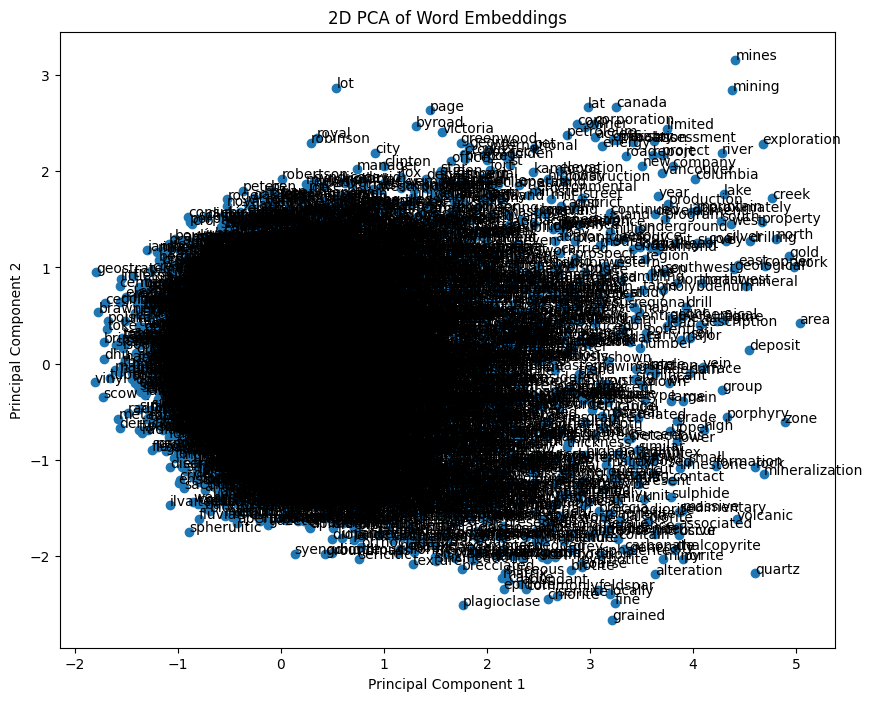

In [ ]:
from sklearn.decomposition import PCA

# Extract the embeddings (all columns except the first one)
embeddings = mydf_filtered.iloc[:, 1:]

# Perform PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a DataFrame for the reduced embeddings
reduced_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
reduced_df['word'] = mydf_filtered.reset_index(drop=True)[0]

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'])

# Annotate the points with the corresponding words
for i, word in enumerate(reduced_df['word']):
    plt.annotate(word, (reduced_df['PC1'][i], reduced_df['PC2'][i]))

plt.title('2D PCA of Word Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Pure PCA on the table seems too messy to interpret, thus applying the interactive graph is required

In [ ]:
reduced_df['word'] = mydf_filtered.reset_index(drop=True)[0]

In [ ]:
from sklearn.cluster import KMeans

# Assume `df` is your DataFrame with columns 'PC1', 'PC2', and 'word'
num_clusters = 10  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
reduced_df['Cluster'] = kmeans.fit_predict(reduced_df[['PC1', 'PC2']])

# Get cluster centroids
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
temp_df = reduced_df[(reduced_df['word'].isin(cities_df['city'])) & (reduced_df['Cluster'] == 0)]
print(temp_df.shape)

(135, 4)


In [ ]:
cities_df[cities_df['city'].isin(temp_df['word'])].groupby('country').count()

,city,city_ascii,lat,lng,iso2,iso3,admin_name,capital,population,id
country,,,,,,,,,,
Argentina,1,1,1,1,1,1,1,1,1,1
Australia,8,8,8,8,8,8,8,2,8,8
Belgium,4,4,4,4,4,4,4,1,4,4
Benin,1,1,1,1,1,1,1,0,1,1
Brazil,4,4,4,4,4,4,4,0,4,4
Bulgaria,1,1,1,1,1,1,1,1,1,1
Burkina Faso,1,1,1,1,1,1,1,0,1,1
Canada,2,2,2,2,2,2,2,0,2,2
Central African Republic,1,1,1,1,1,1,1,1,1,1


In [ ]:
cities_df[cities_df['admin_name'] == 'Zürich']

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1709,zürich,Zurich,47.3744,8.5411,Switzerland,CH,CHE,Zürich,admin,436332.0,1756539143
5456,winterthur,Winterthur,47.4989,8.7286,Switzerland,CH,CHE,Zürich,minor,109775.0,1756362130
8417,dübendorf,Dubendorf,47.4167,8.6167,Switzerland,CH,CHE,Zürich,NaN,28002.0,1756017706
8431,dietikon,Dietikon,47.4000,8.4000,Switzerland,CH,CHE,Zürich,NaN,26936.0,1756546516
9026,opfikon,Opfikon,47.4333,8.5667,Switzerland,CH,CHE,Zürich,NaN,19864.0,1756222668
9178,thalwil,Thalwil,47.2833,8.5667,Switzerland,CH,CHE,Zürich,NaN,18525.0,1756199955
9208,schlieren,Schlieren,47.4000,8.4500,Switzerland,CH,CHE,Zürich,NaN,18731.0,1756013633
9259,adliswil,Adliswil,47.3167,8.5333,Switzerland,CH,CHE,Zürich,NaN,18731.0,1756221733
9540,wallisellen,Wallisellen,47.4150,8.5967,Switzerland,CH,CHE,Zürich,NaN,16315.0,1756960820
10366,männedorf,Mannedorf,47.2553,8.6917,Switzerland,CH,CHE,Zürich,NaN,11242.0,1756961965


In [ ]:
import plotly.express as px

# Create the plot
fig = px.scatter(reduced_df, x='PC1', y='PC2', color='Cluster', hover_data=['word'],
                 title='PCA Plot of Word Embeddings with K-means Clustering')

# Add cluster centroids to the plot
centroid_df = pd.DataFrame(centroids, columns=['PC1', 'PC2'])
centroid_df['Cluster'] = range(num_clusters)
fig.add_scatter(x=centroid_df['PC1'], y=centroid_df['PC2'], mode='markers', marker=dict(size=12, color='black'),
                name='Centroids')

# Show the plot
fig.show()

Voila!

**Calculate the cosin similarities**

Words have their own vectors
Calculating the cosine similarity between them is one of effective ways to capture semantic relation between words

In this one, we have a target word as 'lithium' and find cosine similarity between itself and other words.

In [ ]:
from scipy.spatial.distance import cosine

# Load your data
df = mydf_filtered

# Define cosine similarity function
def compute_cosine_similarity(vector1, vector2):
    return 1 - cosine(vector1, vector2)

# Select target word
target_word = "lithium"

# Compute similarities
target_vector = df[df.iloc[:, 0] == target_word].iloc[:, 1:].values.flatten()
similarities = []
for index, row in df.iterrows():
    word = row.iloc[0]
    word_vector = row.iloc[1:].values
    similarity = compute_cosine_similarity(target_vector, word_vector)
    similarities.append((word, similarity))

# Convert to DataFrame for easier comparison
similarities_df = pd.DataFrame(similarities, columns=['city', 'similarity'])
print(similarities_df.head())

     city  similarity
0    gold   -0.009144
1   mines   -0.185748
2   creek   -0.222610
3    work   -0.085197
4  copper   -0.046915


In [ ]:
similarities_df[similarities_df['city'] == 'perth']

,city,similarity
7217,perth,-0.01342


**Combine city table with similarity**

The point of finding cosine similarity is to find the city with the most which would mean that the city has more connection to the target word.

This method goes by matching the city with cosine similarity(if the city does exist in the embedding table)

In [ ]:
cities_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629
...,...,...,...,...,...,...,...,...,...,...,...
44686,numto,Numto,63.6667,71.3333,Russia,RU,RUS,Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra,NaN,10.0,1643985006
44687,nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,NaN,NaN,10.0,1304217709
44688,timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
44689,san rafael,San Rafael,-16.7795,-60.6799,Bolivia,BO,BOL,Santa Cruz,NaN,NaN,1068007388


In [ ]:
# Assuming cities is a pandas DataFrame
dictionary = cities[['city', 'lat', 'lng', 'country', 'admin_name']]

# Convert the 'city' column to lowercase
dictionary['city'] = dictionary['city'].str.lower()
dictionary.head(5)

<ipython-input-23-11eb61ae5cb2>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,city,lat,lng,country,admin_name
0,tokyo,35.6897,139.6922,Japan,Tōkyō
1,jakarta,-6.1750,106.8275,Indonesia,Jakarta
2,delhi,28.6100,77.2300,India,Delhi
3,guangzhou,23.1300,113.2600,China,Guangdong
4,mumbai,19.0761,72.8775,India,Mahārāshtra


In [ ]:
# Assuming 'dictionary' and 'mydf3' are pandas DataFrames
common_words = pd.Series(list(set(dictionary['city']).intersection(set(similarities_df['city']))))

print(common_words.shape)
# There is a word called nan that got identified as not word, so it got filtered

(1130,)


In [ ]:
similarities_df.sort_values('similarity', ascending=False)

,city,similarity
5987,lithium,1.000000
10516,metaborate,0.718989
4210,fusion,0.538660
3518,inductively,0.533122
3922,spectrometry,0.434614
...,...,...
1870,considerably,-0.304792
102,access,-0.304835
1114,shore,-0.329455
416,good,-0.368623


In [ ]:
# Unzip the word_similarity_pairs to get a list of words and similarity scores
word_list = list(similarities_df['city'])
similarity_list = list(similarities_df['similarity'])

# Create a new dataframe from the word_similarity_pairs
sim_df = pd.DataFrame({
    'city': word_list,
    'similarity': similarity_list
})

# Filter the original dataframe to extract rows that match the words in word_list
filtered_df = dictionary[dictionary['city'].isin(word_list)]

# Merge the filtered dataframe with the similarity dataframe on the 'word' column
merged_df = pd.merge(filtered_df, sim_df, on='city', how='left')

merged_df

,city,lat,lng,country,admin_name,similarity
0,tokyo,35.6897,139.6922,Japan,Tōkyō,0.089528
1,manila,14.5958,120.9772,Philippines,Manila,0.024414
2,beijing,39.9040,116.4075,China,Beijing,0.153552
3,london,51.5072,-0.1275,United Kingdom,"London, City of",-0.023286
4,paris,48.8567,2.3522,France,Île-de-France,-0.009168
...,...,...,...,...,...,...
1868,freeport,43.8556,-70.1009,United States,Maine,0.154774
1869,jackson,39.9057,-76.8796,United States,Pennsylvania,0.102213
1870,windsor,43.2405,-89.2948,United States,Wisconsin,0.044576
1871,barton,42.0812,-76.4982,United States,New York,-0.006203


In [ ]:
# Sort the merged dataframe based on the similarity column in descending order
sorted_df = merged_df.sort_values(by='similarity', ascending=False)

print(sorted_df)

            city      lat       lng        country        admin_name  \
101       manado   1.4931  124.8413      Indonesia    Sulawesi Utara   
823      laramie  41.3099 -105.6085  United States           Wyoming   
35    cincinnati  39.1413  -84.5060  United States              Ohio   
561        pasco  46.2506 -119.1305  United States        Washington   
1102    sherwood  45.3594 -122.8427  United States            Oregon   
...          ...      ...       ...            ...               ...   
65      victoria  48.4283 -123.3647         Canada  British Columbia   
1655    victoria  44.8634  -93.6585  United States         Minnesota   
1319    robinson  40.4578  -80.1334  United States      Pennsylvania   
1488    robinson  31.4501  -97.1201  United States             Texas   
570       mackay -21.1411  149.1858      Australia        Queensland   

      similarity  
101     0.355365  
823     0.311937  
35      0.291255  
561     0.281586  
1102    0.273497  
...          ...  
65

In [ ]:
# sorted_df.to_csv('/content/drive/MyDrive/Research files/sorted_df.csv', index=False)

Now, There are still problems about city with the same name from different countries. We can improve on this furthere by maybe include countries and admin_name into consideration

**Usage of PageRank to find tags**

Why PageRank?
- PageRank is an algorithm used by google to help with searching, by applying node crawl to achieve the word with most connection, thus best representation.
- Applied here to get the representation word for each city
- Each city will have their own tags that emerge from using PageRank algorithm(use cosine similarity as weight, then score it weight by both cosine similarity and PageRank score)

In [ ]:
mydf_filtered

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,gold,0.665368,0.575129,-0.233913,-0.803415,0.541873,-0.284748,-0.587410,0.304050,-0.976940,...,0.664564,-0.326792,-0.166843,0.089043,0.174635,0.708083,-0.211870,-0.922929,0.107179,0.442703
1,mines,-0.061983,-0.611545,0.075108,-1.006732,1.258891,-0.059213,-1.300372,-0.547770,0.142394,...,-0.045271,-0.081380,0.522956,-0.335626,0.570412,0.794796,-0.023208,0.021023,0.607977,-0.573830
2,creek,-0.047574,0.458035,0.221478,-0.578259,0.613073,-0.846475,-0.203815,1.112873,-1.040184,...,-0.104678,-0.689773,-0.158615,0.059416,1.047682,0.612500,0.655737,0.208093,-0.650601,-0.055082
3,work,0.488443,-0.393066,0.145720,-0.665517,0.423911,-0.420992,-0.329604,0.477476,-0.274982,...,-0.463748,0.348744,-0.168836,-0.793235,-0.274093,0.636341,0.018944,0.415261,0.409543,0.393351
4,copper,-0.012102,0.202483,0.003206,-0.243465,1.527658,-0.297196,-0.035213,0.253279,-0.732782,...,0.117608,-0.238600,-0.178582,-0.869530,-0.214733,0.395891,0.251760,0.630467,0.392041,0.138883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12062,xanthate,-0.031826,0.257864,-0.054609,0.185644,-0.256702,0.007058,0.342248,0.009022,-0.007677,...,0.030342,0.134292,0.025772,0.166147,-0.060410,-0.262042,-0.027989,0.021065,-0.031498,-0.007414
12063,yauco,-0.129316,0.196438,0.083277,0.112372,-0.092597,-0.162406,0.167547,0.049535,-0.147225,...,0.039223,0.048401,-0.136274,0.303611,-0.034266,-0.222302,-0.050786,0.147664,0.082796,-0.038463
12064,yearbook,0.161926,-0.127037,-0.179428,0.064139,0.039060,0.316847,-0.100566,-0.017685,-0.085215,...,0.061324,-0.095374,0.105686,0.122895,0.311127,0.216142,-0.028143,0.326211,-0.248389,-0.068676
12065,yest,0.113457,-0.214988,0.029493,0.070235,0.015440,-0.153996,0.007843,-0.117899,-0.028560,...,0.016367,0.091974,-0.056424,0.105577,-0.001417,-0.104674,-0.058605,-0.099760,0.224277,-0.158745


In [ ]:
Anchor_word = 'perth'

addition_row = mydf_filtered[mydf_filtered[0] == Anchor_word]
addition_row

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
7217,perth,-0.411047,0.052891,-0.322415,0.104269,-0.265338,0.092422,0.233678,0.03611,-0.284285,...,0.074665,-0.089602,0.322519,-0.088312,-0.189576,0.202694,-0.022269,0.044595,0.001253,-0.16949


In [ ]:
# Function to add a row if the word doesn't already exist
def add_word_embedding(df, new_row):
    word = new_row.iloc[0, 0]  # Assuming the word is in the first column of new_row
    if word in df.iloc[:, 0].values:
        print(f"Word '{word}' already exists. Row not added.")
    else:
        df = pd.concat([df, new_row], ignore_index=True)
        print(f"Row added successfully for '{word}'.")

    return df

nltk_filtered_table_added = add_word_embedding(mydf_filtered, addition_row)
nltk_filtered_table_added

Word 'perth' already exists. Row not added.


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,gold,0.665368,0.575129,-0.233913,-0.803415,0.541873,-0.284748,-0.587410,0.304050,-0.976940,...,0.664564,-0.326792,-0.166843,0.089043,0.174635,0.708083,-0.211870,-0.922929,0.107179,0.442703
1,mines,-0.061983,-0.611545,0.075108,-1.006732,1.258891,-0.059213,-1.300372,-0.547770,0.142394,...,-0.045271,-0.081380,0.522956,-0.335626,0.570412,0.794796,-0.023208,0.021023,0.607977,-0.573830
2,creek,-0.047574,0.458035,0.221478,-0.578259,0.613073,-0.846475,-0.203815,1.112873,-1.040184,...,-0.104678,-0.689773,-0.158615,0.059416,1.047682,0.612500,0.655737,0.208093,-0.650601,-0.055082
3,work,0.488443,-0.393066,0.145720,-0.665517,0.423911,-0.420992,-0.329604,0.477476,-0.274982,...,-0.463748,0.348744,-0.168836,-0.793235,-0.274093,0.636341,0.018944,0.415261,0.409543,0.393351
4,copper,-0.012102,0.202483,0.003206,-0.243465,1.527658,-0.297196,-0.035213,0.253279,-0.732782,...,0.117608,-0.238600,-0.178582,-0.869530,-0.214733,0.395891,0.251760,0.630467,0.392041,0.138883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12062,xanthate,-0.031826,0.257864,-0.054609,0.185644,-0.256702,0.007058,0.342248,0.009022,-0.007677,...,0.030342,0.134292,0.025772,0.166147,-0.060410,-0.262042,-0.027989,0.021065,-0.031498,-0.007414
12063,yauco,-0.129316,0.196438,0.083277,0.112372,-0.092597,-0.162406,0.167547,0.049535,-0.147225,...,0.039223,0.048401,-0.136274,0.303611,-0.034266,-0.222302,-0.050786,0.147664,0.082796,-0.038463
12064,yearbook,0.161926,-0.127037,-0.179428,0.064139,0.039060,0.316847,-0.100566,-0.017685,-0.085215,...,0.061324,-0.095374,0.105686,0.122895,0.311127,0.216142,-0.028143,0.326211,-0.248389,-0.068676
12065,yest,0.113457,-0.214988,0.029493,0.070235,0.015440,-0.153996,0.007843,-0.117899,-0.028560,...,0.016367,0.091974,-0.056424,0.105577,-0.001417,-0.104674,-0.058605,-0.099760,0.224277,-0.158745


In [ ]:
tags_table = nltk_filtered_table_added.sample(11000)

words = tags_table.iloc[:, 0].tolist()
words

['midget',
 'precipitated',
 'roosevelt',
 'reliability',
 'pitted',
 'stadia',
 'bloc',
 'dispersive',
 'jaguar',
 'utility',
 'bronze',
 'intensity',
 'extended',
 'surrender',
 'equally',
 'barometer',
 'heap',
 'near',
 'fountain',
 'uniform',
 'containment',
 'document',
 'chess',
 'traversed',
 'igneous',
 'banded',
 'baker',
 'authorization',
 'adsorb',
 'crawford',
 'probability',
 'minim',
 'capped',
 'agglomeratic',
 'lassie',
 'grounding',
 'catface',
 'jackfish',
 'chilled',
 'wave',
 'brunswick',
 'jumbo',
 'ribbed',
 'deformation',
 'sag',
 'dispose',
 'audio',
 'pablo',
 'deodorizer',
 'schedule',
 'pato',
 'omen',
 'habitat',
 'sphere',
 'radioactive',
 'nant',
 'aeration',
 'heat',
 'snugly',
 'everett',
 'conversation',
 'kimberlite',
 'geomorphology',
 'earthquake',
 'lade',
 'wrote',
 'petrography',
 'demonstrable',
 'moss',
 'sulphidic',
 'seeded',
 'spruce',
 'dealer',
 'electro',
 'santa',
 'regulation',
 'minter',
 'pinched',
 'fa',
 'dirty',
 'peripheral',
 'rh

In [ ]:
embeddings = tags_table.iloc[:, 1:].values
embeddings

array([[ 0.112842,  0.258777, -0.253573, ...,  0.128551,  0.163869,
         0.267254],
       [-0.627822, -0.342277, -0.653963, ...,  0.087672, -0.499277,
        -0.378268],
       [-0.598549, -0.135598,  0.256111, ...,  0.864377,  0.041931,
        -0.259371],
       ...,
       [-0.143243,  0.032228, -0.035862, ..., -0.023197, -0.048338,
         0.064082],
       [-0.181722, -0.028188,  0.330574, ..., -0.063053,  0.094065,
         0.130148],
       [ 0.07755 ,  0.102566,  0.007883, ...,  0.009483,  0.088872,
        -0.223289]])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Create a graph
G = nx.Graph()

# Add nodes (words)
for word in words:
    G.add_node(word)

# Add edges with similarity as weights
threshold = 0.1  # Similarity threshold
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if similarity_matrix[i][j] > threshold:
            G.add_edge(words[i], words[j], weight=similarity_matrix[i][j])

# Calculate PageRank
pagerank_scores = nx.pagerank(G, weight='weight')
print("PageRank Scores:")
print(pagerank_scores)

In [ ]:
# Step 1: Sort the dictionary items by value in descending order
sorted_items = sorted(pagerank_scores.items(), key=lambda item: item[1], reverse=True)

# Step 2: Get the top 10 items
top_10_items = sorted_items[:10]

# Step 3: Print the top 10 items
for key, value in top_10_items:
    print(f"{key}: {value}")

PageRank score samples

Now, the weight between cosine sim and PageRank score is 0.5.

cosine sim indicate how similar the word to the target and PageRank would act as complementatry tie breaker/additional indicator

In [ ]:
# Define the target word
target_word = 'perth'
target_index = words.index(target_word)

# Find similar words to 'gold' based on similarity scores
similar_words = [(words[i], similarity_matrix[target_index][i]) for i in range(len(words)) if i != target_index and similarity_matrix[target_index][i] > threshold]


In [ ]:
similar_words

In [ ]:
# Define weights
alpha = 0.5  # Weight for similarity
beta = 0.5   # Weight for PageRank

In [ ]:
# Compute combined score
combined_scores = [(word, alpha * similarity + beta * pagerank_scores[word]) for word, similarity in similar_words]

# Sort by combined score
combined_scores_sorted = sorted(combined_scores, key=lambda x: x[1], reverse=True)

# Print the words with combined scores
print(f"Words that best describe '{target_word}' based on combined scores:")
for word, score in combined_scores_sorted:
    print(f"Word: {word}, Similarity: {similarity_matrix[target_index][words.index(word)]:.2f}, PageRank: {pagerank_scores[word]:.4f}, Combined Score: {score:.4f}")

In [ ]:
# Create a DataFrame
data = []
for word, score in combined_scores_sorted:
    data.append({
        "Word": word,
        "Similarity": similarity_matrix[target_index][words.index(word)],
        "PageRank": pagerank_scores[word],
        "Combined Score": score
    })

score_dataframe = pd.DataFrame(data)

# Print the DataFrame
print(score_dataframe.head(10))

**Start Plotting the location of cities onto the map**

From the combination of the cities table and similarities, we use the corresponding city name and the latitude and longitude to pinpoint a location on the world map

In [ ]:
pip install cartopy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
data = sorted_df.head(10)
data.head(10)

In [ ]:
data = data.head(10)

latitudes = data['lat'].tolist()
longitudes = data['lng'].tolist()

print("First 10 Latitudes:", latitudes)
print("First 10 Longitudes:", longitudes)

In [ ]:
sim_values = data['similarity'].tolist()

# Normalize color values to range [0, 1]
norm = plt.Normalize(min(sim_values), max(sim_values))

print("First 5 sim_values:", sim_values)

In [ ]:
# Create a matplotlib figure and axis with Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot latitude and longitude data with colors
scatter = ax.scatter(longitudes, latitudes, c=sim_values, cmap='viridis', norm=norm, s=100, marker='o', alpha=0.8)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Color Bar Label')

# Customize the plot (add title, grid, etc.)
ax.set_title('Latitude and Longitude Plot')
ax.gridlines(draw_labels=True)  # Add gridlines with labels
ax.coastlines()  # Add coastlines

# Show the plot
plt.show()